<a href="https://colab.research.google.com/github/cytrus2012/bachelorthesis/blob/main/Christofides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

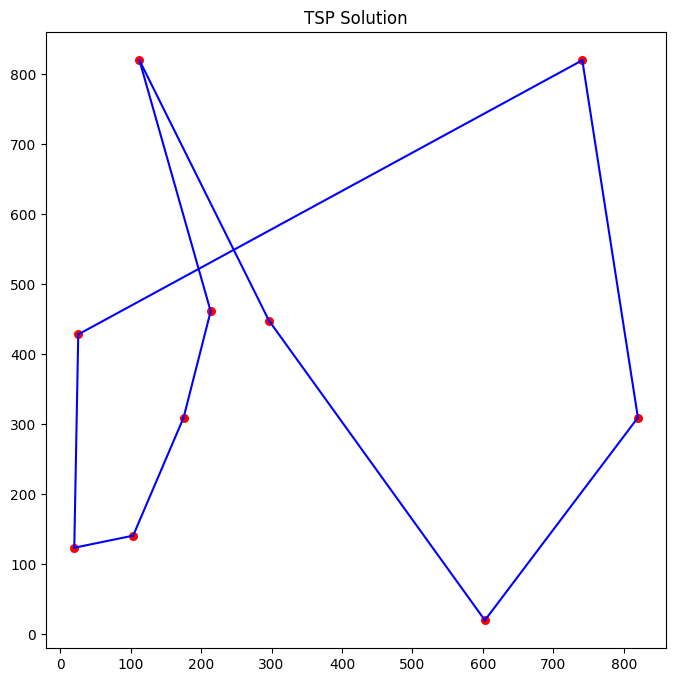

(11295.322606837204, [5, 8, 3, 7, 9, 2, 4, 1, 0, 6, 5])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

def tsp(data, visualize=False):
    """
    Solve the Traveling Salesman Problem using the Christofides algorithm
    with an optional visualization.

    Parameters:
        data (list of tuples): List of (x, y) coordinates representing the nodes.
        visualize (bool): If True, displays the process of finding the solution.

    Returns:
        tuple: The length of the path and the path itself as a list of nodes.
    """
    # Build the complete graph based on distances between nodes
    G = build_graph(data)

    # Create a Minimum Spanning Tree (MST) from the graph
    MSTree = minimum_spanning_tree(G)

    # Find vertices with odd degrees in the MST
    odd_vertexes = find_odd_vertexes(MSTree)

    # Perform minimum weight matching to make the graph Eulerian
    minimum_weight_matching(MSTree, G, odd_vertexes)

    # Create an Eulerian tour from the Eulerian graph
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # Convert Eulerian tour to Hamiltonian path by skipping visited nodes
    path, length = convert_to_hamiltonian(eulerian_tour, G)

    if visualize:
        visualize_tsp_solution(data, path)

    return length, path


def get_length(x1, y1, x2, y2):
    """
    Calculate Euclidean distance between two points.
    """
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def build_graph(data):
    """
    Build a complete graph with distances as edge weights.

    Parameters:
        data (list of tuples): Node coordinates.

    Returns:
        dict: Adjacency matrix representation of the graph.
    """
    graph = {}
    for i in range(len(data)):
        for j in range(len(data)):
            if i != j:
                graph.setdefault(i, {})[j] = get_length(data[i][0], data[i][1], data[j][0], data[j][1])
    return graph


class UnionFind:
    """
    Union-Find data structure for tracking disjoint sets.
    """

    def __init__(self):
        self.parents = {}
        self.ranks = {}

    def find(self, node):
        """
        Find the root of a node with path compression.
        """
        if self.parents.get(node, node) != node:
            self.parents[node] = self.find(self.parents[node])
        return self.parents.get(node, node)

    def union(self, node1, node2):
        """
        Union two disjoint sets by rank.
        """
        root1, root2 = self.find(node1), self.find(node2)
        if root1 != root2:
            if self.ranks.get(root1, 1) > self.ranks.get(root2, 1):
                self.parents[root2] = root1
            elif self.ranks.get(root1, 1) < self.ranks.get(root2, 1):
                self.parents[root1] = root2
            else:
                self.parents[root2] = root1
                self.ranks[root1] = self.ranks.get(root1, 1) + 1


def minimum_spanning_tree(G):
    """
    Generate a Minimum Spanning Tree (MST) using Kruskal's algorithm.

    Parameters:
        G (dict): Adjacency matrix representation of the graph.

    Returns:
        list of tuples: List of edges (u, v, weight) in the MST.
    """
    edges = sorted((weight, u, v) for u in G for v, weight in G[u].items())
    uf = UnionFind()
    tree = []

    for weight, u, v in edges:
        if uf.find(u) != uf.find(v):
            uf.union(u, v)
            tree.append((u, v, weight))

    return tree


def find_odd_vertexes(MST):
    """
    Find vertices with odd degrees in the MST.

    Parameters:
        MST (list of tuples): Edges of the MST.

    Returns:
        list: Vertices with odd degrees.
    """
    degree_count = {}
    for u, v, _ in MST:
        degree_count[u] = degree_count.get(u, 0) + 1
        degree_count[v] = degree_count.get(v, 0) + 1

    return [vertex for vertex, degree in degree_count.items() if degree % 2 == 1]


def minimum_weight_matching(MST, G, odd_vertices):
    """
    Add edges to the MST to create a graph with all vertices of even degree.

    Parameters:
        MST (list): Current MST edges.
        G (dict): Adjacency matrix of the graph.
        odd_vertices (list): Vertices with odd degrees.
    """
    random.shuffle(odd_vertices)

    while odd_vertices:
        v = odd_vertices.pop()
        closest = min(
            ((u, G[v][u]) for u in odd_vertices if u != v),
            key=lambda x: x[1],
            default=(None, float('inf'))
        )
        if closest[0] is not None:
            MST.append((v, closest[0], closest[1]))
            odd_vertices.remove(closest[0])


def find_eulerian_tour(MST, G):
    """
    Create an Eulerian tour from the graph.

    Parameters:
        MST (list): Edges of the Eulerian graph.

    Returns:
        list: Eulerian tour as a sequence of vertices.
    """
    neighbors = {}
    for u, v, _ in MST:
        neighbors.setdefault(u, []).append(v)
        neighbors.setdefault(v, []).append(u)

    tour = []
    stack = [MST[0][0]]

    while stack:
        current = stack[-1]
        if neighbors[current]:
            next_vertex = neighbors[current].pop()
            neighbors[next_vertex].remove(current)
            stack.append(next_vertex)
        else:
            tour.append(stack.pop())

    return tour


def convert_to_hamiltonian(eulerian_tour, G):
    """
    Convert an Eulerian tour to a Hamiltonian path by skipping visited nodes.

    Parameters:
        eulerian_tour (list): Eulerian tour as a sequence of vertices.
        G (dict): Adjacency matrix of the graph.

    Returns:
        tuple: Length of the path and the Hamiltonian path.
    """
    visited = set()
    path = []
    length = 0

    for node in eulerian_tour:
        if node not in visited:
            if path:
                length += G[path[-1]][node]
            path.append(node)
            visited.add(node)

    # Return to the starting point
    length += G[path[-1]][path[0]]
    path.append(path[0])

    return path, length


def visualize_tsp_solution(cities, path):
    """
    Visualize the TSP solution.

    Parameters:
        cities (list of tuples): Coordinates of cities.
        path (list): Hamiltonian path.
    """
    cities = np.array(cities)
    screen_size = 800

    # Scale coordinates for display
    min_x, max_x = np.min(cities[:, 0]), np.max(cities[:, 0])
    min_y, max_y = np.min(cities[:, 1]), np.max(cities[:, 1])

    scaled_cities = [
        (
            (city[0] - min_x) / (max_x - min_x) * screen_size + 20,
            (city[1] - min_y) / (max_y - min_y) * screen_size + 20,
        )
        for city in cities
    ]

    plt.figure(figsize=(8, 8))

    for i in range(len(path) - 1):
        start = scaled_cities[path[i]]
        end = scaled_cities[path[i + 1]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'b-')

    # Draw cities
    for x, y in scaled_cities:
        plt.scatter(x, y, c='red', s=30)

    plt.title("TSP Solution")
    plt.show()


# Example usage with visualization enabled
coordinates = [
    (1380, 939), (2848, 96), (3510, 1671), (457, 334), (3888, 666), (984, 965),(500, 1671), (57, 300), (800, 666), (84, 900)
]
tsp(coordinates, visualize=True)